# 过拟合、欠拟合及其解决方案
- 过拟合、欠拟合的概念
- 权重衰减
- 丢弃法

## 训练误差和泛化误差
我们需要区分训练误差（training error）和泛化误差（generalization error）。通俗来讲，前者指模型在训练数据集上表现出的
误差，后者指模型在任意一个测试数据样本上表现出的误差的期望，并常常通过测试数据集上的误差来近似。机器学习模型应关注降低
泛化误差。

## 模型选择

### 验证数据集
预留一部分在训练数据集和测试数据集以外的数据来进行模型选择。这部分数据被称为验证数据集，简称验证集（validation set）。

### K折交叉验证
K折交叉验证（K-fold cross-validation），把原始训练数据集分割成K个不重合的子数据集，然后我们做K次模型训练和验证。每一次，
我们使用一个子数据集验证模型，并使用其他K-1个子数据集来训练模型。在这K次训练和验证中，每次用来验证模型的子数据集都不同。
最后，我们对这K次训练误差和验证误差分别求平均。

## 过拟合和欠拟合
- 一类是模型无法得到较低的训练误差，我们将这一现象称作欠拟合（underfitting）；
- 另一类是模型的训练误差远小于它在测试数据集上的误差，我们称该现象为过拟合（overfitting）。

### 模型复杂度
$$\hat y = b + \sum\limits_{k=1}^K x^k w_k$$
其中$x$数据特征，$y$是标签，$w_k$是权重参数，$b$是偏差参数。
![模型复杂度](../img/Snipaste_2020-02-15_11-45-50.png)

### 训练数据大小
影响欠拟合和过拟合的另一个重要因素是训练数据集的大小。一般来说，如果训练数据集中样本数过少，特别是比模型参数数量（按元素计）更少时，过拟合更容易发生。此外，泛化误差不会随训练数据集里样本数量增加而增大。因此，在计算资源允许的范围之内，我们通常希望训练数据集大一些，特别是在模型复杂度较高时，例如层数较多的深度学习模型。


## 多项式函数拟合实验

In [1]:
%matplotlib inline
import torch
import numpy as np
import sys
import utils

In [3]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1)
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
         + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype = torch.float)

In [4]:
features[:2], poly_features[:2], labels[:2]

(tensor([[ 1.0379],
         [-0.1471]]), tensor([[ 1.0379,  1.0773,  1.1182],
         [-0.1471,  0.0216, -0.0032]]), tensor([8.8480, 4.7366]))

## 定义、训练和测试

In [5]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
            legend=None, figsize=(3.5, 2.5)):
    utils.plt.xlabel(x_label)
    utils.plt.ylabel(y_label)
    utils.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        utils.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        utils.plt.legend(legend)

In [6]:
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    # 初始化网络模型
    net = torch.nn.Linear(train_features.shape[-1], 1)
    
    # 设置批量大小
    batch_size = min(10, train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)   # 设置数据集
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)   # 设置获取数据的方式
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)  # 设置优化函数
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
        
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epoch', 'loss',
            range(1, num_epochs + 1), test_ls,['train', 'test'])
    print('weight:', net.weight.data,
         '\nbias:', net.bias.data)

### 三阶多项式函数拟合（正常）

final epoch: train loss 0.00012242168304510415 test loss 0.0001816152798710391
weight: tensor([[ 1.2107, -3.3980,  5.5977]]) 
bias: tensor([4.9982])


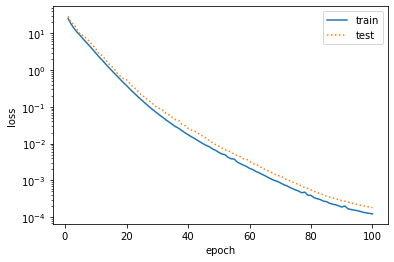

In [7]:
# 正常
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

final epoch: train loss 85.81580352783203 test loss 140.66482543945312
weight: tensor([[16.4317]]) 
bias: tensor([2.7840])


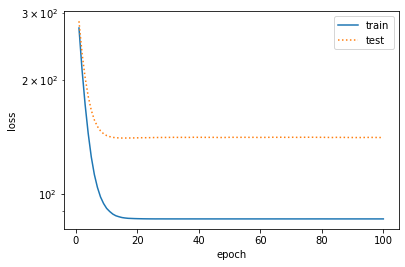

In [8]:
# 欠拟合
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

final epoch: train loss 0.8076079487800598 test loss 270.9419250488281
weight: tensor([[1.6224, 2.1325, 1.2514]]) 
bias: tensor([3.6801])


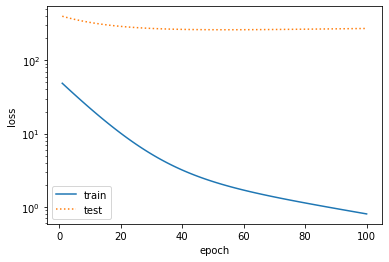

In [9]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2], labels[n_train:])

## 权重衰减
### 方法
#### L2正则
$$l(w_1, w_2, b) = \frac{1}{n}\sum\limits_{i=1}^n \frac{1}{2}(x_1^(i)w_1 + x_2^{i}w_2 + b - y^{(i)})^2$$

$$w_1 \gets (1- \frac{\eta \lambda}{|\beta|})w_1 - \frac{\eta}{|\beta|}\sum\limits_{i \epsilon \beta}x_1^{(i)}(x_1^{(1)}w_1 + x_2^{(i)}w_2 + b - y^{(i)}) $$
$$w_2 \gets (1- \frac{\eta \lambda}{|\beta|})w_2 - \frac{\eta}{|\beta|}\sum\limits_{i \epsilon \beta}x_1^{(i)}(x_1^{(1)}w_1 + x_2^{(i)}w_2 + b - y^{(i)}) $$

## 高维线性回归实验
$$y = 0.05 + \sum\limits_{i = 1}^p 0.01 x_i + \epsilon$$
其中$\epsilon$ 服从$mean = 0, std = 0.01$的正态分布

In [10]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
import utils

print(torch.__version__)

1.2.0


### 初始化模型参数

In [11]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [12]:
# 定义参数初始化函数，初始化模型参数并且附上梯度
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### 定义L2范数惩罚项

In [13]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

### 定义训练和测试

In [16]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = utils.linreg, utils.squared_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            # 添加了L2范数惩罚项
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            utils.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    utils.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

L2 norm of w: 13.377153396606445


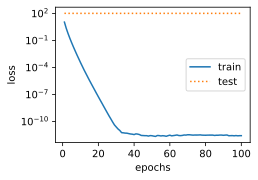

In [17]:
# 过拟合
fit_and_plot(lambd=0)

L2 norm of w: 0.024551933631300926


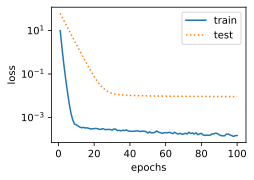

In [18]:
# 使用权重衰减
fit_and_plot(lambd=3)

In [ ]:
# TODO pytorch 实现